In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss, Conv2d, Sequential, BatchNorm2d
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchinfo import summary

from ActiveShiftLayer import ASL
from util import test_loss, train_NN

In [2]:
torch.zeros(1).cuda()

RuntimeError: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero.

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(device)

cpu


/home/max/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
torch.__version__

'1.12.1+cu116'

In [3]:
batch_size = 100

#transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [7]:
from Models import LeNet

input_shape = (batch_size, 1, 28, 28)

LeNN = LeNet(input_shape, num_labels=10)

summary(LeNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Conv2d: 2-5                       [100, 16, 14, 14]         2,416
│    └─BatchNorm2d: 2-6                  [100, 16, 14, 14]         32
│    └─Tanh: 2-7                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-8                    [100, 16, 7, 7]           --
│    └─Flatten: 2-9                      [100, 784]                --
│    └─Linear: 2-10                      [100, 120]                94,200
│    └─Tanh: 2-11                        [100, 120]                --
│    └─

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [6]:
leStats = train_NN(LeNN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.483
test_loss: 0.165, test_accuracy: 94.97
[1,   400] train_loss: 0.161
test_loss: 0.111, test_accuracy: 96.55
[1,   600] train_loss: 0.127
test_loss: 0.102, test_accuracy: 96.92
[2,   200] train_loss: 0.079
test_loss: 0.089, test_accuracy: 97.39
[2,   400] train_loss: 0.072
test_loss: 0.067, test_accuracy: 97.86
[2,   600] train_loss: 0.064
test_loss: 0.065, test_accuracy: 98.1
[3,   200] train_loss: 0.046
test_loss: 0.052, test_accuracy: 98.38
[3,   400] train_loss: 0.042
test_loss: 0.052, test_accuracy: 98.43
[3,   600] train_loss: 0.038
test_loss: 0.048, test_accuracy: 98.53
[4,   200] train_loss: 0.030
test_loss: 0.044, test_accuracy: 98.71
[4,   400] train_loss: 0.032
test_loss: 0.047, test_accuracy: 98.57
[4,   600] train_loss: 0.030
test_loss: 0.045, test_accuracy: 98.49


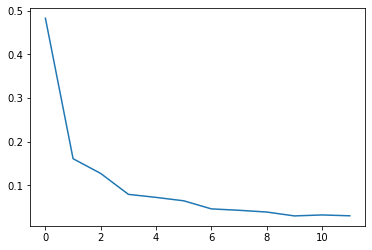

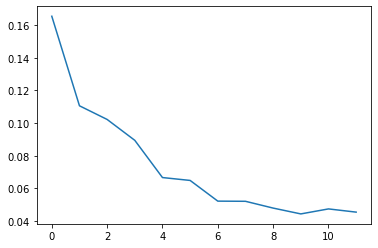

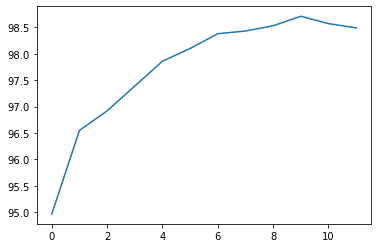

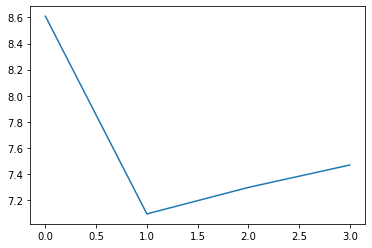

In [7]:
plt.plot(leStats[0])
plt.show()
plt.plot(leStats[1])
plt.show()
plt.plot(leStats[2])
plt.show()
plt.plot(leStats[3])
plt.show()

In [8]:
from Models import LeASLNet

input_shape = (batch_size, 1, 28, 28)

LeASLNN = LeASLNet(input_shape, 10, device, expansion_rate=1)

summary(LeASLNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeASLNet                                 [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─CSC_block: 2-5                    [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        178
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [9]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeASLNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [10]:
leASLStats = train_NN(LeASLNN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.468
test_loss: 0.141, test_accuracy: 95.77
[1,   400] train_loss: 0.124
test_loss: 0.083, test_accuracy: 97.36
[1,   600] train_loss: 0.106
test_loss: 0.078, test_accuracy: 97.57
[2,   200] train_loss: 0.060
test_loss: 0.061, test_accuracy: 98.09
[2,   400] train_loss: 0.054
test_loss: 0.050, test_accuracy: 98.39
[2,   600] train_loss: 0.057
test_loss: 0.046, test_accuracy: 98.5
[3,   200] train_loss: 0.040
test_loss: 0.039, test_accuracy: 98.83
[3,   400] train_loss: 0.033
test_loss: 0.040, test_accuracy: 98.72
[3,   600] train_loss: 0.040
test_loss: 0.039, test_accuracy: 98.71
[4,   200] train_loss: 0.031
test_loss: 0.036, test_accuracy: 98.73
[4,   400] train_loss: 0.028
test_loss: 0.037, test_accuracy: 98.67
[4,   600] train_loss: 0.030
test_loss: 0.035, test_accuracy: 98.79


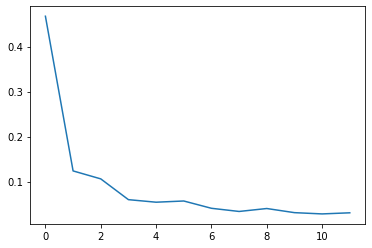

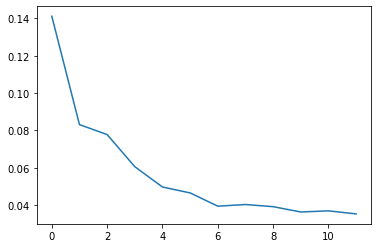

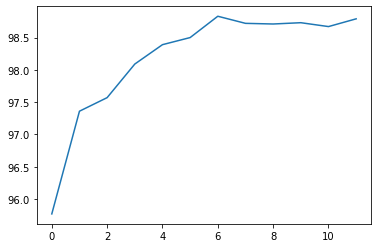

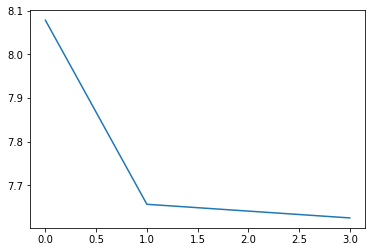

In [11]:
plt.plot(leASLStats[0])
plt.show()
plt.plot(leASLStats[1])
plt.show()
plt.plot(leASLStats[2])
plt.show()
plt.plot(leASLStats[3])
plt.show()

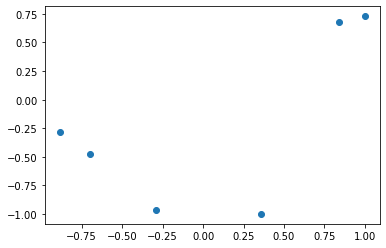

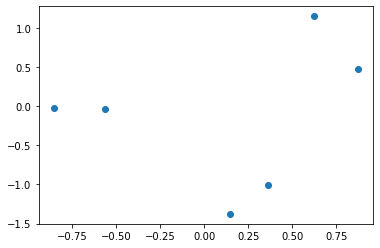

In [12]:
points = LeASLNN.NN[4].NN[3].shifts.detach().to("cpu").numpy()
initial_points = LeASLNN.NN[4].NN[3].initial.detach().to("cpu").numpy()
plt.scatter(initial_points[:, 0], initial_points[:,1])
plt.show()
plt.scatter(points[:, 0], points[:,1])
plt.show()

In [4]:
from Models import LeDepthNet

input_shape = (100, 1, 28, 28)

LeDepthNN = LeDepthNet(input_shape, 10, device)

summary(LeDepthNN, input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
LeDepthNet                               [100, 10]                 --
├─Sequential: 1-1                        --                        --
│    └─Conv2d: 2-1                       [100, 6, 28, 28]          156
│    └─BatchNorm2d: 2-2                  [100, 6, 28, 28]          12
│    └─Tanh: 2-3                         [100, 6, 28, 28]          --
│    └─AvgPool2d: 2-4                    [100, 6, 14, 14]          --
│    └─Depth_wise_block: 2-5             [100, 16, 14, 14]         --
│    │    └─Sequential: 3-1              --                        226
│    └─Tanh: 2-6                         [100, 16, 14, 14]         --
│    └─AvgPool2d: 2-7                    [100, 16, 7, 7]           --
│    └─Flatten: 2-8                      [100, 784]                --
│    └─Linear: 2-9                       [100, 120]                94,200
│    └─Tanh: 2-10                        [100, 120]                --
│    └─Li

In [5]:
criterion = CrossEntropyLoss()
optimizer = optim.SGD(LeDepthNN.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

In [6]:
leDepthStats = train_NN(LeDepthNN, train_dataloader,
        test_dataloader, epochs=4, optimizer=optimizer, criterion=criterion,
        scheduler=scheduler, device=device, steps_to_test=200, print_test=True)

[1,   200] train_loss: 0.479
test_loss: 0.139, test_accuracy: 95.8
[1,   400] train_loss: 0.128
test_loss: 0.090, test_accuracy: 97.2
[1,   600] train_loss: 0.089
test_loss: 0.078, test_accuracy: 97.61
[2,   200] train_loss: 0.051
test_loss: 0.050, test_accuracy: 98.38
[2,   400] train_loss: 0.054
test_loss: 0.051, test_accuracy: 98.39
[2,   600] train_loss: 0.052
test_loss: 0.045, test_accuracy: 98.59
[3,   200] train_loss: 0.032
test_loss: 0.039, test_accuracy: 98.73
[3,   400] train_loss: 0.032
test_loss: 0.040, test_accuracy: 98.66
[3,   600] train_loss: 0.034
test_loss: 0.037, test_accuracy: 98.71
[4,   200] train_loss: 0.025
test_loss: 0.037, test_accuracy: 98.75
[4,   400] train_loss: 0.024
test_loss: 0.035, test_accuracy: 98.76
[4,   600] train_loss: 0.025
test_loss: 0.035, test_accuracy: 98.77


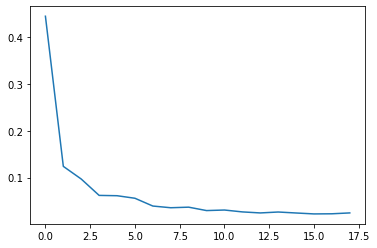

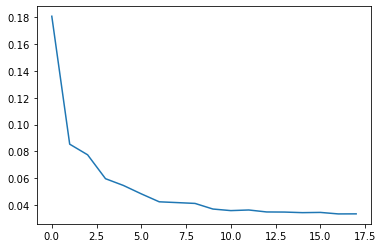

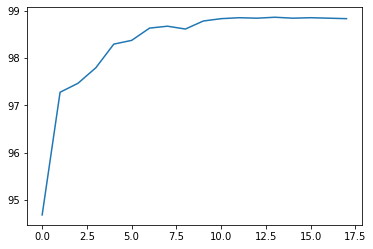

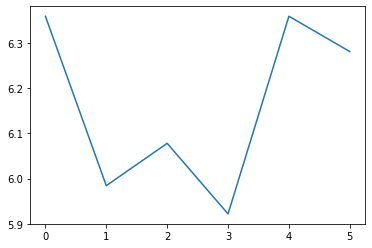

In [16]:
plt.plot(leDepthStats[0])
plt.show()
plt.plot(leDepthStats[1])
plt.show()
plt.plot(leDepthStats[2])
plt.show()
plt.plot(leDepthStats[3])
plt.show()